# Examining Behavior of SPX Options on Expiration Day

### 1) Data Cleaning and Preparation
- Consolidate intraday minutely data from daily SPX yahoo pulls
- Consolidate VIX intraday prices from daily VIX options files
- Consolidate 0 DTE expiration options from daily SPX options pulls
- Retrieve live minutely data from Alphavantage

### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min, 10 min, 15 min, 20 min, 30 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

### 3) Relationship of VIX Intraday to 0 DTE Option IV
- Check if VIX and IV use calendar or trading days to annualize
    - **IV on the options chain is in calendar years with 24 hour days -> minutes_remaining/(60 x 24 x 365.25)**
- Determine Function of Skew using 3rd and 4th moments
- Plot IV surface against strikes and time of day
- Check behavior of IV movement given VIX term structure is in Contango or Backwardation

### 4) Expiration Day Option Pricing
- Implied Binomial Pricing model using probability inferred from option prices
- Monte Carlo using implied binomial probabilities then backing out he IV from simulated option prices
- Use Black Scholes but IV based on VIX intraday or HV from intraday SPX
- **Track the IV live on the option chain in IB and use BS to calculate the delta to confirm validity**


### 5) 1 DTE Overnight Options Short Vol
- Test buckets of VIX brackets and put spreads from 1 hour, 2 hour, or 3 hours before market close and premium the next day
- Test overnight volatility vs intraday volatility of SPX during high IV and low IV
- Test intraday VIX correlation with SPX and trends
- Use ARIMA for trend significance throughout the day
- Use ADF for mean reversion significance throughout the day
- Infer (r - q) from ES and SPX spot prices and see whether they conform to options prices of SPX and ES

##### Importing Necessary Modules

In [611]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas.stats.moments as st
import statsmodels.tsa.stattools as ts
from pandas_datareader.data import Options
pd.options.display.float_format = '{:,.4f}'.format

import numpy as np
import datetime as dt
import time
import matplotlib.pyplot as plt

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

from sqlalchemy import *
from sqlalchemy import create_engine
import sqlite3 as sql
from scipy.stats import norm as norm

import py_vollib.black.greeks.analytical as py_greeks
import py_vollib.ref_python.black_scholes as py_bs
import py_vollib.ref_python.black_scholes.implied_volatility as py_iv

import os
main_dir = os.getcwd()
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\RetiredModules')
from helpers import maturities
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')
cleaned_dir = 'D:\\Options Data\\Aggregated DBs'
from yahoo_query import *

def alpha_vantage(ticker, key):
    if key == 0:
        api_key = '5HZEUI5AFJB06BUK'
    else:
        api_key = '6ZAZOL7YF8VPXND7'
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={0}&interval=1min&outputsize=full&apikey={1}&datatype=csv' 
    df = pd.read_csv(url.format(ticker, api_key), index_col = 0).sort_index()
    df.index = pd.to_datetime(df.index)    
    return df

from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.graphics.tsaplots import plot_acf


##### 1) Data Preparation

In [376]:
# Retrieving Data for VIX Term Structure
v1 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX1.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
v2 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX2.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', skiprows=[0], index_col = 0)
vix.index = pd.to_datetime(vix.index)
vix_term = vix.join(v1.join(v2, lsuffix = '_F1', rsuffix = '_F2').dropna()).dropna()
vix_term['Front_Weights'] = np.nan
vix_term['Back_Weights'] = np.nan

for index, row in vix_term.iterrows():
    weights = maturities(index.date())
    front_weight = weights[0]
    back_weight = weights[1]
    vix_term.loc[index, 'Front_Weights'] = front_weight
    vix_term.loc[index, 'Back_Weights'] = back_weight
    
vix_term = vix_term[list(filter(lambda x: 'Open' in x or 'Weight' in x, vix_term.columns.tolist()))]
vix_term['Contango_Ratio'] = vix_term.Front_Weights*(vix_term['VIX Open']/vix_term.Open_F1) + vix_term.Back_Weights*(vix_term.Open_F1/vix_term.Open_F2)
vix_term = vix_term[vix_term.index >= dt.datetime(2018,7,30)]

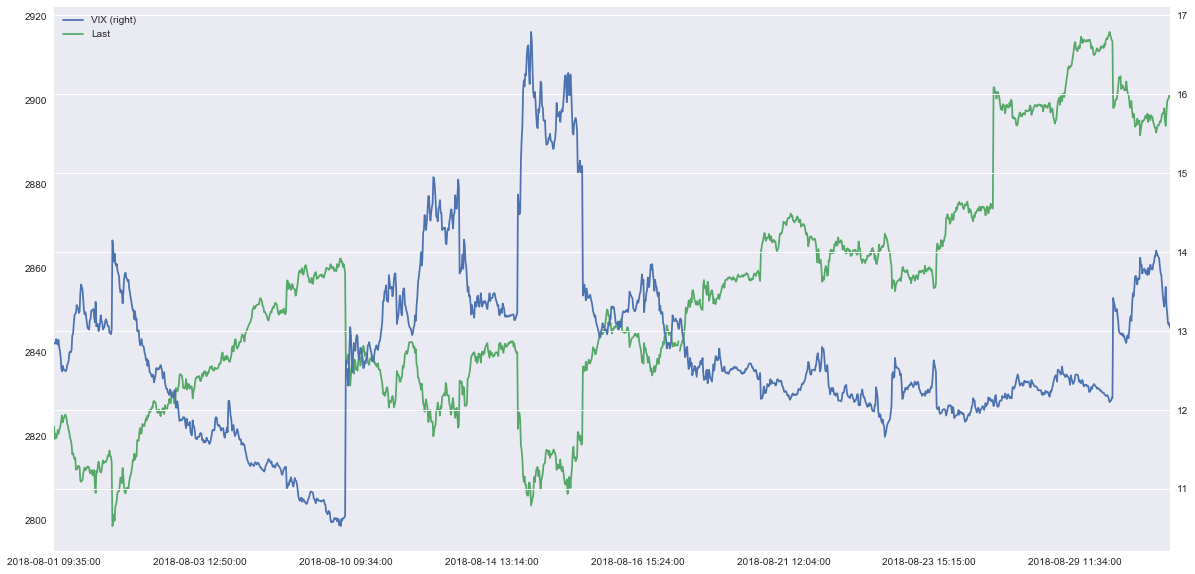

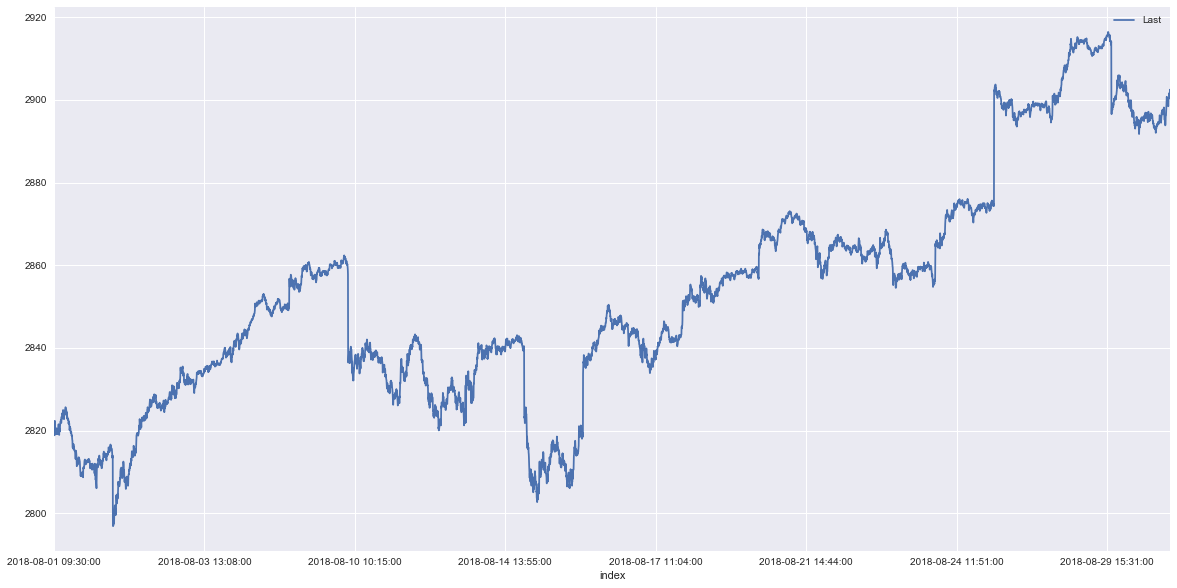

In [377]:
# Retrieving Data For Intraday SPX and VIX Indices from Local Databases
os.chdir(cleaned_dir)

non_trading_days = [dt.date(2018,10,10), dt.date(2018,9,3), dt.date(2018,12,24),
                    dt.date(2018,12,25), dt.date(2019,1,1), dt.date(2018,8,7), 
                    dt.date(2018,8,9), dt.date(2018,8,27), dt.date(2018,8,30),
                    dt.date(2018,9,13), dt.date(2018,9,14), dt.date(2018,11,28)]

bad_options_data = [dt.datetime(2018,11,1), dt.datetime(2018,11,5), dt.datetime(2018,11,6),
                    dt.datetime(2018,11,8), dt.datetime(2018,11,12), dt.datetime(2018,11,26),
                    dt.datetime(2018,11,26), dt.datetime(2018,11,29)]

non_trading_days = ["day_{}".format(x.strftime("%Y-%m-%d")) for x in non_trading_days]

lookup_date = dt.date(2018,8,1)

options_db = 'sqlite:///options_{0}-{1}.db'.format(lookup_date.year,lookup_date.month)
spx_db = 'sqlite:///spx_intraday_{0}-{1}.db'.format(lookup_date.year,lookup_date.month)
index_db = 'sqlite:///indices_intraday_{0}-{1}.db'.format(lookup_date.year,lookup_date.month)

options_engine = create_engine(options_db, echo = False)
spx_engine = create_engine(spx_db, echo = False)
index_engine = create_engine(index_db, echo = False)

indices_intraday_df = []
for table in index_engine.table_names():
    if table in non_trading_days:
        continue
    query = 'SELECT * FROM "{}"'.format(table)
    try:
        index_table = pd.read_sql_query(query, con = index_engine, index_col = 'index')
    except:
        index_table = pd.read_sql_query(query, con = index_engine, index_col = 'Quote_Time')
    
    index_table.index = pd.to_datetime(index_table.index)
#    index_table.plot(figsize = (20,10), secondary_y = 'VIX')
#    print(table)
#    plt.show()
    indices_intraday_df.append(index_table)

indices_intraday_df = pd.concat(indices_intraday_df, axis = 0)

spx_intraday_df = []
for table in spx_engine.table_names():
    if table in non_trading_days:
        continue
    query = 'SELECT * FROM "{}"'.format(table)
    try:
        spx_table = pd.read_sql_query(query, con = spx_engine, index_col = 'index')
    except:
        spx_table = pd.read_sql_query(query, con = spx_engine, index_col = 'Quote_Time')
    
    spx_table.index = pd.to_datetime(spx_table.index)
    #spx_table.plot(figsize = (20,10))
    #print(table)
    #plt.show()
    spx_intraday_df.append(spx_table)
    
spx_intraday_df = pd.concat(spx_intraday_df, axis = 0)

indices_intraday_df.plot(x=indices_intraday_df.index.astype(str),
                         figsize = (20,10), secondary_y = 'VIX')

plt.show()

spx_intraday_df.plot(x=spx_intraday_df.index.astype(str),
                         figsize = (20,10))
plt.show()

##### 2) Initial Check of SPX Spot Behavior Intraday
- Test for random walk
    - Check 1 min, 5 min intervals on:
        - Entire day
        - Segmented times in the day, e.g., hourly behavior, half-hour behavior, etc.
    - Perform DF test
    - Calculate probability of price movements using volatility windows and simulating price behavior

**ADF test for random walk** <br>
- The test statistic is a negative number and thus in order to be significant beyond the critical values, the number must be more negative than these values, i.e. less than the critical values.
- The ADF null hypothesis is that the process is a random walk and thus non mean-reverting (i.e., a high p-value indicates that we fail to reject the null that it is a random walk)
- The output of the Augmented Dickey-Fuller test over a period is as follows:
    - The first value is the calculated test-statistic
    - The second value is the p-value.
    - The fourth is the number of data points in the sample. 
    - The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

**Hurst Exponent Test for Stationarity** <br>
A time series can then be characterised in the following manner:
- H < 0.5 - The time series is mean reverting
- H = 0.5 - The time series is a Geometric Brownian Motion
- H > 0.5 - The time series is trending

**Autocorrelation is highest most often during the times of 9:30 AM to 10:00 AM and 1:00 PM to 2:00 PM** <br>
**Non-mean reverting series occurs most often at 9:30 AM to 10:00 AM and from 1:00 PM to 3:00 PM**

In [380]:
def intraday_ts_tests(price_series, curr_date, use_5min = False):
    
    day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
    day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
    block_series = [price_series[(price_series.index >= block[0]) & 
                                 (price_series.index <= block[1])] for block in day_blocks]
    if use_5min:
        block_series[0] = price_series[(price_series.index <= dt.datetime(curr_date.year,
                                                                          curr_date.month, 
                                                                          curr_date.day, 10, 30))]

    return [ts.adfuller(price_series.Last)[1]] + [ts.adfuller(block.Last)[1] for block in block_series]

def spx_trend(minute_data, lookback_minutes = 60):
    import statsmodels.api as sm
    
    try:
        spx_trend = minute_data[['spx_close']].dropna().tail(lookback_minutes)
    except:
        trend_table = pd.DataFrame({'SPX Intraday Summaries': [0,0]}, index = ['Trend Magnitude','Trend Strength'])
        return trend_table
    else:
        spx_trend = minute_data.pct_change().dropna()*100
        spx_trend = spx_trend.reset_index(drop = True)
        X = spx_trend.index ## X usually means our input variables (or independent variables)
        y = spx_trend["spx_close"] ## Y usually means our output/dependent variable
        X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

        # Note the difference in argument order
        spx_trend = sm.OLS(y, X).fit().summary()
        #trend_strength = pd.read_html(spx_trend.tables[0].as_html())[0].loc[0,2:].reset_index(drop = True)
        #trend_magnitude = pd.read_html(spx_trend.tables[1].as_html())[0].loc[:,1].reset_index(drop = True)
        #trend_table = pd.concat([trend_magnitude,trend_strength], axis = 1).T.set_index(0)
        #trend_table.columns = ['SPX Intraday Summaries']
        #trend_table.index = ['Trend Magnitude','Trend Strength']
        print(spx_trend)
        return #trend_table

def create_stats_df(interval_dict):
    for i, k in enumerate(interval_dict.keys()):
        if i == 0:
            curr_interval_df = pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates())
        else:
            curr_interval_df = curr_interval_df.join(pd.DataFrame(interval_dict[k], index = spx_intraday.Date.drop_duplicates()),
                                                     rsuffix = '_{}'.format(k))

    return curr_interval_df

# intervals_1min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
#                   'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
#                   'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
#                   'timeblock6': {'hurst':[],'adf':[]}}
# intervals_5min = {'full_day': {'hurst':[],'adf':[]}, 'timeblock1': {'hurst':[],'adf':[]},
#                   'timeblock2': {'hurst':[],'adf':[]}, 'timeblock3': {'hurst':[],'adf':[]},
#                   'timeblock4': {'hurst':[],'adf':[]}, 'timeblock5': {'hurst':[],'adf':[]},
#                   'timeblock6': {'hurst':[],'adf':[]}}

# for curr_date in spx_intraday.Date.drop_duplicates().tolist():

#     curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
#     curr_5min = curr_day_spx.iloc[::5, :]    
    
#     curr_1min_tests = intraday_ts_tests(curr_day_spx, curr_date)
#     curr_5min_tests = intraday_ts_tests(curr_5min, curr_date, True)
    
#     i = 0
#     for k,v in intervals_1min.items():
#         intervals_1min[k]['adf'].append(curr_1min_tests[i][0])

#         i += 1
        
#     i = 0
#     for k,v in intervals_5min.items():
#         intervals_5min[k]['adf'].append(curr_5min_tests[i][0])

#         i += 1
        
# intervals_1min = create_stats_df(intervals_1min)
# intervals_5min = create_stats_df(intervals_5min)

In [379]:
adfs_1min = intervals_1min[list(filter(lambda x: 'adf' in x, intervals_1min.columns.tolist()))]
adfs_5min = intervals_5min[list(filter(lambda x: 'adf' in x, intervals_5min.columns.tolist()))]

hurst_1min = intervals_1min[list(filter(lambda x: 'hurst' in x, intervals_1min.columns.tolist()))]
hurst_5min = intervals_5min[list(filter(lambda x: 'hurst' in x, intervals_5min.columns.tolist()))]

idx = ['full_day', 'timeblock1', 'timeblock2', 'timeblock3','timeblock4', 'timeblock5', 'timeblock6']

adf_summary = {'adf_1min':[],
                 'adf_5min':[]}

for col in adfs_1min.columns:
    adf_summary['adf_1min'].append(len(adfs_1min[adfs_1min[col] < 0.05]))
    adf_summary['adf_5min'].append(len(adfs_5min[adfs_5min[col] < 0.05]))

AttributeError: 'dict' object has no attribute 'columns'

In [391]:
day_blocks = [dt.datetime(curr_date.year, curr_date.month, curr_date.day, x) for x in range(9,17)]
day_blocks = [day_blocks[i:i + 2] for i in range(len(day_blocks) - 1)]
time_blocks = [str([x.strftime('%H:%M') for x in block]).replace('[','').replace(']','').replace("'",'') for block in day_blocks]

hurst_1min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

hurst_5min_summary = {'mr_counts':[],
                      'gbm_counts':[],
                      'trend_counts':[]}

for col in hurst_1min.columns:
    hurst_1min_summary['mr_counts'].append(len(hurst_1min[hurst_1min[col] < 0.4]))
    hurst_1min_summary['trend_counts'].append(len(hurst_1min[hurst_1min[col] > 0.6]))
    hurst_1min_summary['gbm_counts'].append(len(hurst_1min[(hurst_1min[col] <= 0.6) & (hurst_1min[col] >= 0.4)]))
    
for col in hurst_5min.columns:
    hurst_5min_summary['mr_counts'].append(len(hurst_5min[hurst_5min[col] < 0.4]))
    hurst_5min_summary['trend_counts'].append(len(hurst_5min[hurst_5min[col] > 0.6]))
    hurst_5min_summary['gbm_counts'].append(len(hurst_5min[(hurst_5min[col] <= 0.6) & (hurst_5min[col] >= 0.4)]))

pd.DataFrame(adf_summary,index = idx).join(pd.DataFrame(hurst_1min_summary,index = idx),
                                           rsuffix = '_hurst1').join(pd.DataFrame(hurst_5min_summary,index = idx),
                                                                     rsuffix = '_hurst5')

,adf_1min,adf_5min,gbm_counts,mr_counts,trend_counts,gbm_counts_hurst5,mr_counts_hurst5,trend_counts_hurst5
full_day,12,12,0,108,0,0,108,0
timeblock1,17,9,0,107,0,1,107,0
timeblock2,7,3,0,107,0,0,107,0
timeblock3,8,6,0,107,0,0,108,0
timeblock4,12,3,0,108,0,0,108,0
timeblock5,12,13,0,108,0,0,108,0
timeblock6,5,7,0,107,0,0,107,0


In [432]:
autocorr_idx = idx + ['timeblock7']

intervals_1min_autocorr = {k:[] for k in autocorr_idx}
intervals_5min_autocorr = {k:[] for k in autocorr_idx}

for curr_date in spx_intraday.Date.drop_duplicates().tolist():

    curr_day_spx = spx_intraday[spx_intraday.Date == curr_date][['Last']]
    curr_5min = curr_day_spx.iloc[::5, :]    

    autocorrs_1min = intraday_autocorr(curr_day_spx, curr_date)
    autocorrs_5min = intraday_autocorr(curr_5min, curr_date)
    
    for i,v in enumerate(autocorrs_1min):
        intervals_1min_autocorr[autocorr_idx[i]].append(v)
    
    for i,v in enumerate(autocorrs_5min):
        intervals_5min_autocorr[autocorr_idx[i]].append(v)

intervals_1min_autocorr = pd.DataFrame(intervals_1min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())
intervals_5min_autocorr = pd.DataFrame(intervals_5min_autocorr, index = spx_intraday.Date.drop_duplicates().tolist())

In [450]:
autocorr_1min_summary = {k:[] for k in intervals_1min_autocorr.columns}
autocorr_5min_summary = {k:[] for k in intervals_5min_autocorr.columns}

for col in intervals_1min_autocorr.columns:
    autocorr_1min_summary[col].append(len(intervals_1min_autocorr[abs(intervals_1min_autocorr[col]) > 0.3]))
    autocorr_5min_summary[col].append(len(intervals_5min_autocorr[abs(intervals_5min_autocorr[col]) > 0.3]))

In [451]:
pd.DataFrame(autocorr_1min_summary, 
             index = ['interval_1min']).T.join(pd.DataFrame(autocorr_5min_summary,
                                                            index = ['interval_5min']).T)

,interval_1min,interval_5min
full_day,0,0
timeblock1,11,67
timeblock2,3,28
timeblock3,2,40
timeblock4,2,25
timeblock5,2,27
timeblock6,3,30
timeblock7,4,37


In [707]:
spx = yahoo_query('^GSPC', dt.datetime(2018,11,1))
vix = yahoo_query('^VIX', dt.datetime(2018,11,1))

spx.hist_prices_query()
spx.minute_query()
vix.hist_prices_query()
vix.minute_query()

spx.minute_prices.columns = [x.replace('^GSPC', 'spx') for x in spx.minute_prices.columns.tolist()]
spx.hist_prices.columns = [x.replace('^GSPC', 'spx') for x in spx.hist_prices.columns.tolist()]
vix.hist_prices.columns = [x.replace('^VIX', 'vix') for x in vix.hist_prices.columns.tolist()]
vix.minute_prices.columns = [x.replace('^VIX', 'vix') for x in vix.minute_prices.columns.tolist()]

In [708]:
for i in range(20, len(spx.minute_prices[spx.minute_prices.index >= dt.datetime(max(spx.minute_prices.index).year,
                                                                                max(spx.minute_prices.index).month,
                                                                                max(spx.minute_prices.index).day)]), 20):
    adf_n_period = ts.adfuller(np.log(spx.minute_prices.spx_close.dropna().tail(i)))
    
    print('Lookback {} Periods:'.format(i))
    print('ADF Significance:')
    print(adf_n_period[1])
    spx_trend(spx.minute_prices[['spx_close']].dropna().tail(i))
    print('')

Lookback 20 Periods:
ADF Significance:
0.95853208606
                            OLS Regression Results                            
Dep. Variable:              spx_close   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.2536
Date:                Fri, 01 Feb 2019   Prob (F-statistic):              0.621
Time:                        12:22:34   Log-Likelihood:                 41.862
No. Observations:                  19   AIC:                            -79.72
Df Residuals:                      17   BIC:                            -77.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:              spx_close   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3289
Date:                Fri, 01 Feb 2019   Prob (F-statistic):              0.567
Time:                        12:22:34   Log-Likelihood:                 469.37
No. Observations:                 199   AIC:                            -934.7
Df Residuals:                     197   BIC:                            -928.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.003     -1.273      0.2

In [709]:
# spx.minute_prices['Relative20DayVolume'] = spx.minute_prices.spx_volume/spx.hist_prices.spx_volume.tail(20).mean()

spx.minute_prices['RelativeVolume'] = spx.minute_prices['spx_volume']/pd.expanding_mean(spx.minute_prices.spx_volume, 2)
spx.minute_prices['UpDirection'] = (spx.minute_prices.spx_close.pct_change() >= 0)*1
spx.minute_prices['DownDirection'] = (spx.minute_prices.spx_close.pct_change() < 0)*-1
spx.minute_prices['RelativeVolume'] = spx.minute_prices['RelativeVolume']*spx.minute_prices['DownDirection'] + spx.minute_prices['RelativeVolume']*spx.minute_prices['UpDirection']
spx.minute_prices['UpVolume'] = spx.minute_prices['UpDirection']*spx.minute_prices['spx_volume']
spx.minute_prices['DownVolume'] = spx.minute_prices['DownDirection']*spx.minute_prices['spx_volume']
print(spx.minute_prices[['UpVolume','DownVolume']].sum())
spx.minute_prices

UpVolume      863,791,839.0000
DownVolume   -819,539,057.0000
dtype: float64


,spx_close,spx_high,spx_low,spx_open,spx_volume,RelativeVolume,UpDirection,DownDirection,UpVolume,DownVolume
2019-02-01 10:30:00,"2,704.9399","2,704.9399","2,703.9099","2,703.9099",0.0000,nan,0,0,0.0000,0.0000
2019-02-01 10:31:00,"2,706.4399","2,706.4399","2,705.3101","2,705.3101","12,578,529.0000",2.0000,1,0,"12,578,529.0000",0.0000
2019-02-01 10:32:00,"2,704.5801","2,705.8000","2,704.5801","2,705.8000","12,602,142.0000",-1.5014,0,-1,0.0000,"-12,602,142.0000"
2019-02-01 10:33:00,"2,704.6399","2,704.6399","2,703.8701","2,703.8701","8,383,652.0000",0.9991,1,0,"8,383,652.0000",0.0000
2019-02-01 10:34:00,"2,705.3501","2,705.3501","2,704.4700","2,704.9299","13,035,815.0000",1.3987,1,0,"13,035,815.0000",0.0000
2019-02-01 10:35:00,"2,706.5500","2,706.5500","2,705.2800","2,705.2800","12,666,613.0000",1.2823,1,0,"12,666,613.0000",0.0000
2019-02-01 10:36:00,"2,706.6599","2,706.8401","2,706.6599","2,706.8401","9,254,751.0000",0.9454,1,0,"9,254,751.0000",0.0000
2019-02-01 10:37:00,"2,705.8301","2,706.7800","2,705.8301","2,706.7800","8,801,566.0000",-0.9106,0,-1,0.0000,"-8,801,566.0000"
2019-02-01 10:38:00,"2,705.0801","2,705.4299","2,705.0801","2,705.4299","8,793,615.0000",-0.9190,0,-1,0.0000,"-8,793,615.0000"
2019-02-01 10:39:00,"2,706.4399","2,706.4399","2,705.2100","2,705.2100","9,455,204.0000",0.9893,1,0,"9,455,204.0000",0.0000


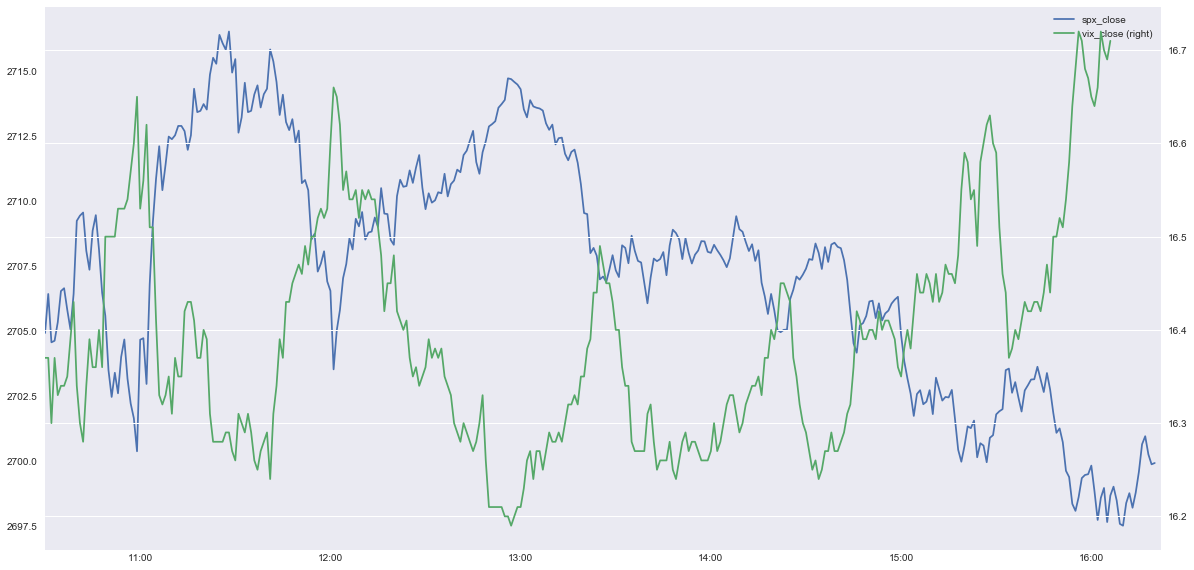

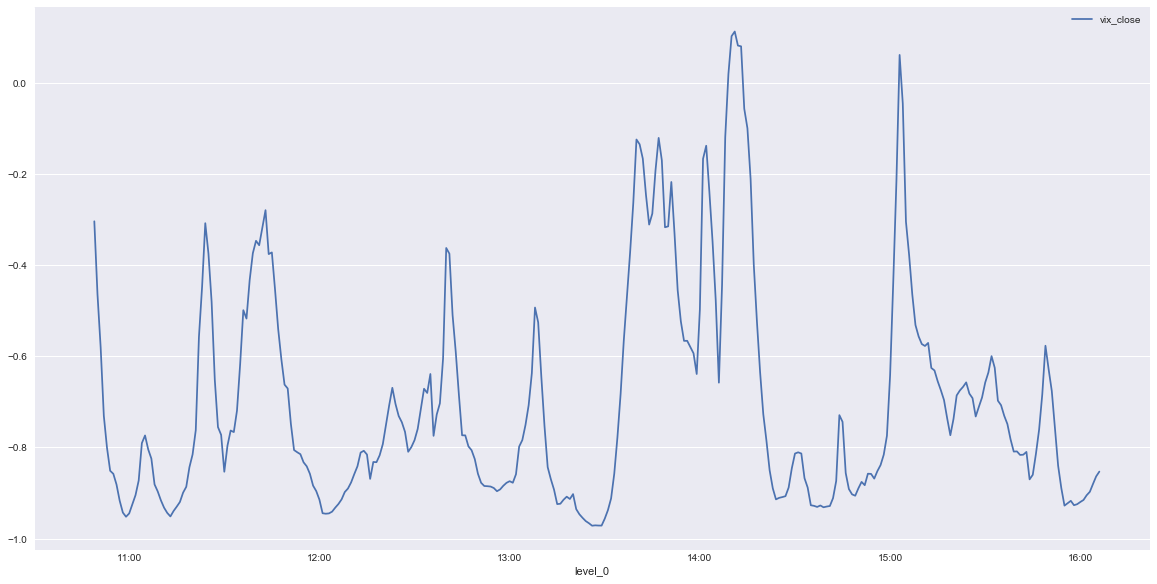

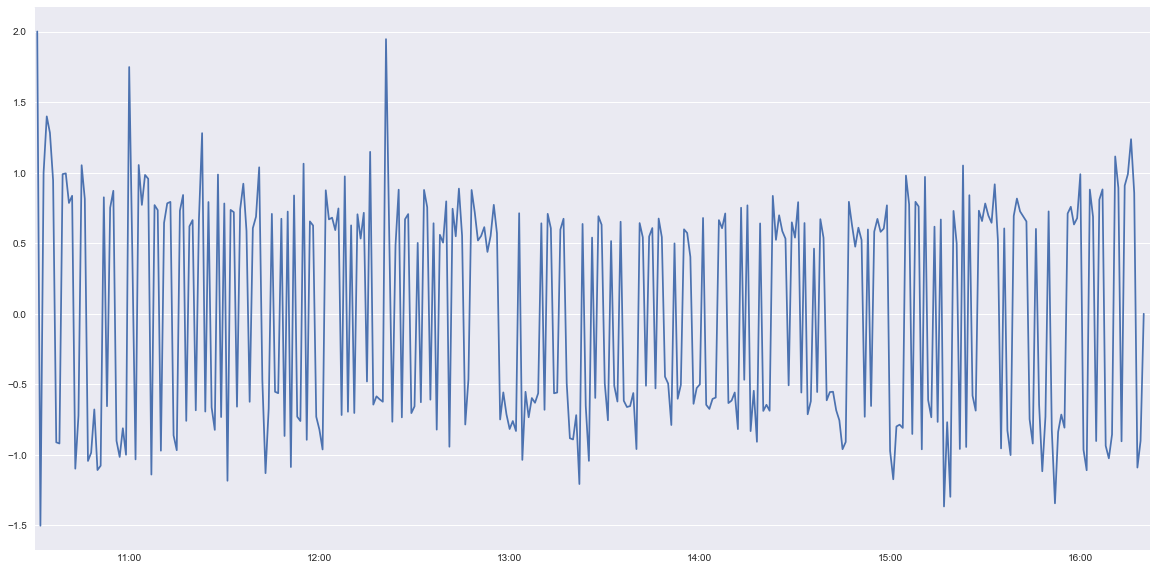

In [710]:
curr_indices = pd.concat([spx.minute_prices[['spx_close']], vix.minute_prices[['vix_close']]],axis = 1).fillna(method='bfill')
curr_indices.plot(figsize = (20,10), secondary_y = 'vix_close')
plt.show()
curr_indices.rolling(20).corr().reset_index().drop_duplicates('level_0', 
                                                              keep = 'first').set_index('level_0')[['vix_close']].plot(figsize = (20,10))
plt.show()
spx.minute_prices['RelativeVolume'].plot(figsize = (20,10))

In [605]:

def bsm_prices(s, k, daily_iv, curr_time = dt.datetime.now().time()):
    day_min = 390
    time_remaining = dt.datetime.combine(dt.date.today(), dt.time(13,0)) - dt.datetime.combine(dt.date.today(), curr_time)
    time_remaining = time_remaining.seconds/60
    day_remaining = time_remaining/day_min

    daily_iv = daily_iv/100
    d1 = (np.log(s/k) + (daily_iv**2/2)*day_remaining)/(daily_iv*np.sqrt(day_remaining))
    d2 = d1 - daily_iv*np.sqrt(day_remaining)

    call_price = norm.cdf(d1)*s - norm.cdf(d2)*k
    put_price = norm.cdf(-d2)*k - norm.cdf(-d1)*s

    put_parity_price = k - s + call_price
    call_parity_price = s - k + put_price

    price_df = pd.DataFrame({'call_price': call_price, 'put_price': put_price, 
                             'put_parity_price': put_parity_price, 'call_parity_price': call_parity_price},
                            index = ['prices'])
    return price_df



In [646]:
short_k = 2640
short_iv = 0.64

long_k = 2645
long_iv = 0.72
r = 0
flag = 'c'
s = 2640

curr_time = dt.time(9,30)

time_remaining = dt.datetime.combine(dt.date.today(), dt.time(13,0)) - dt.datetime.now()
time_remaining = time_remaining.seconds/60
t = time_remaining/(24*60*365)

py_iv.implied_volatility(15.75, s, long_k, t, r, flag)

0.6203183029825828